Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.signal import butter, lfilter
from google.colab import files

Auto-Cloud Implementation

In [2]:
class DataCloud:
	N=0
	def __init__(self,x):
		self.n=1
		self.mean=x
		self.variance=0
		self.pertinency=1
		self.eccAn=0
		DataCloud.N+=1
	def addDataClaud(self,x):
		self.n=2
		self.mean=(self.mean+x)/2
		self.variance=((np.linalg.norm(self.mean-x))**2)
	def updateDataCloud(self,n,mean,variance):
		self.n=n
		self.mean=mean
		self.variance=variance

In [3]:
class AutoCloud:
	c= np.array([DataCloud(0)],dtype=DataCloud)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		AutoCloud.m = m
		AutoCloud.c= np.array([DataCloud(0)],dtype=DataCloud)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.classIndex = []
		AutoCloud.k = 1		

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#updating intersection list
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#updating data clouds list 
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#remove lines
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remove columns
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculating new column
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculating new line
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#updating column
					M1[:,i]=col
					#updating line
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;   
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1
				
	def run(self,X):
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				eccentricity=(1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(AutoCloud.k-2)
				data.eccAn = eccentricity
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection.itemset(i,1)
				else:
					AutoCloud.alfa[i] = 0
					AutoCloud.listIntersection.itemset(i,0)
				i+=1
			
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0)) 
			self.mergeClouds()
			AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			classIndex = np.argmax(AutoCloud.relevanceList)
			AutoCloud.classIndex.append(classIndex)

        
		AutoCloud.k=AutoCloud.k+1


Time filter implementation

In [4]:
def filter_time(signal_input,e1 = 20, e2 = 60):
  result = []
  for i in range(e1):
    result.append(0)
  for i in range(e1, len(signal_input)):
    if(signal_input[i] == 0 and np.sum(signal_input[i-e1:i] == signal_input[i]) == e1):
      result.append(signal_input[i])
    elif(signal_input[i] != 0 and  np.sum(signal_input[i-e2:i] == signal_input[i]) == e2):
      result.append(signal_input[i])
    else:
      result.append(result[len(result)-1])
  return np.array(result)

# First fault scenario

Load data set

In [5]:
data_fault_1 = pd.read_csv('f_01_06.csv')
constrained_vars = ["%0d" % v for v in [2,3]]
data_f = np.array(data_fault_1[constrained_vars])
df = pd.DataFrame(data_f, columns=['1','2'])


Pre-processing

In [6]:
import pandas as pd
from sklearn import preprocessing

x = data_f
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_f = x_scaled

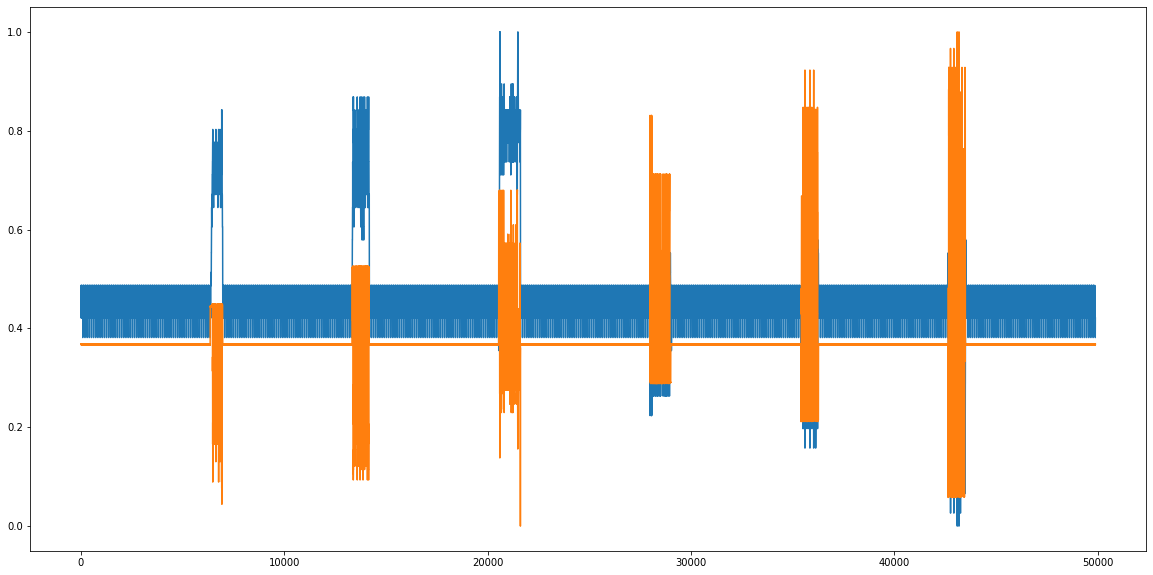

In [7]:
plt.figure(figsize=(20,10)) 
plt.plot(data_f)
plt.show()

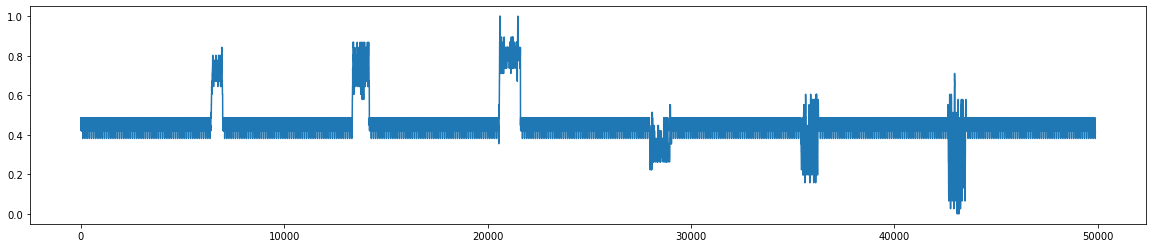

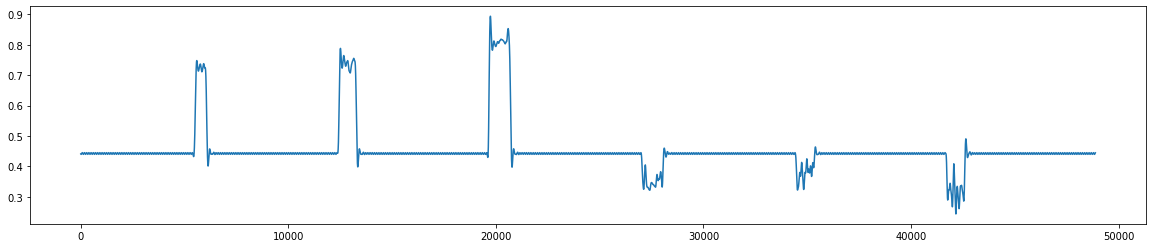

In [8]:
freq = 400
cutoff = 5

data = data_f[:,0]
plt.figure(figsize=(20,4)) 
plt.plot(data)
plt.show()
b, a = butter(5, (cutoff/freq), btype='low', analog=False)
data = lfilter(b, a, data)[1000:]
plt.figure(figsize=(20,4)) 
plt.plot(data)
plt.show()

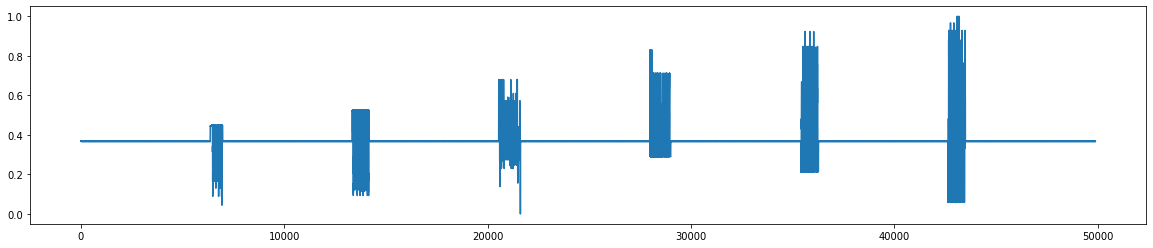

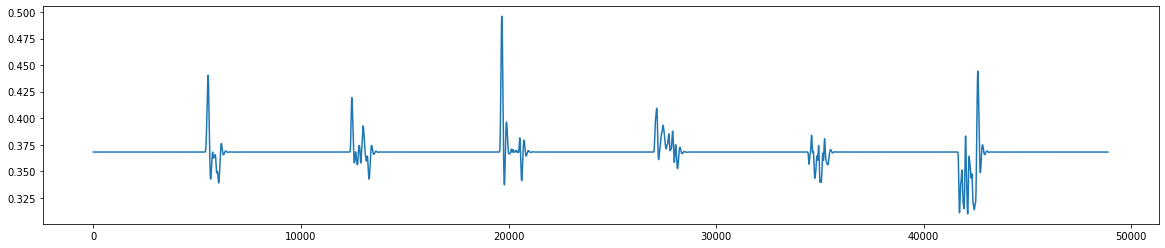

In [9]:
freq = 500
cutoff = 5

data_1 = data_f[:,1]
plt.figure(figsize=(20,4)) 
plt.plot(data_1)
plt.show()
b, a = butter(5, (cutoff/freq), btype='low', analog=False)
data_1 = lfilter(b, a, data_1)[1000:]
plt.figure(figsize=(20,4))
plt.plot(data_1)
plt.show()

In [10]:
result_window = pd.DataFrame(data)
result_window = result_window.rolling(window=4).mean()
data = result_window.values


result_window = pd.DataFrame(data_1)
result_window = result_window.rolling(window=1).mean()
data_1 = result_window.values

data = data[3:,0]
data_1 = data_1[3:,0]

data_f = np.array([data,data_1]).T

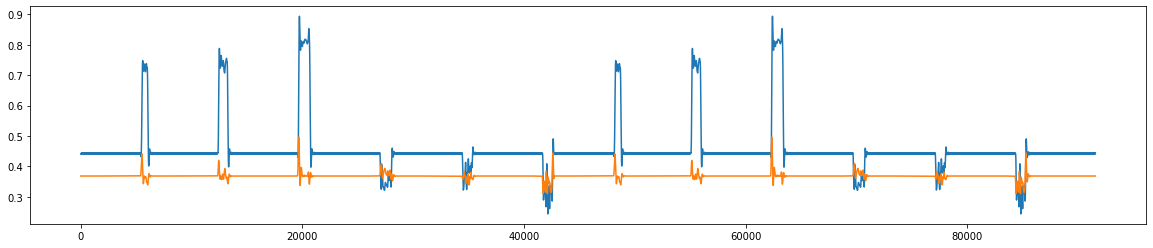

In [11]:
data_f = np.concatenate((data_f[:42699],data_f))
plt.figure(figsize=(20,4)) 
plt.plot(data_f)
plt.show()

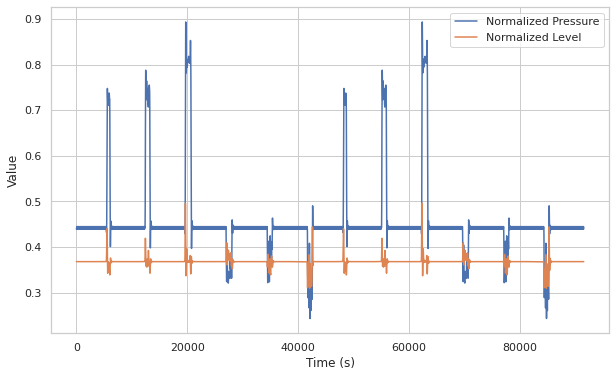

In [12]:
plt.figure(figsize=(10,6)) 
sns.set(style= 'whitegrid' )
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.plot(data_f[:,0])
plt.plot(data_f[:,1])
plt.legend(["Normalized Pressure","Normalized Level"])
plt.show()

In [13]:
teste = AutoCloud(2.48)
for t in data_f:
    teste.run(np.array(t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


In [14]:
result_f = np.array(teste.classIndex)

Results 

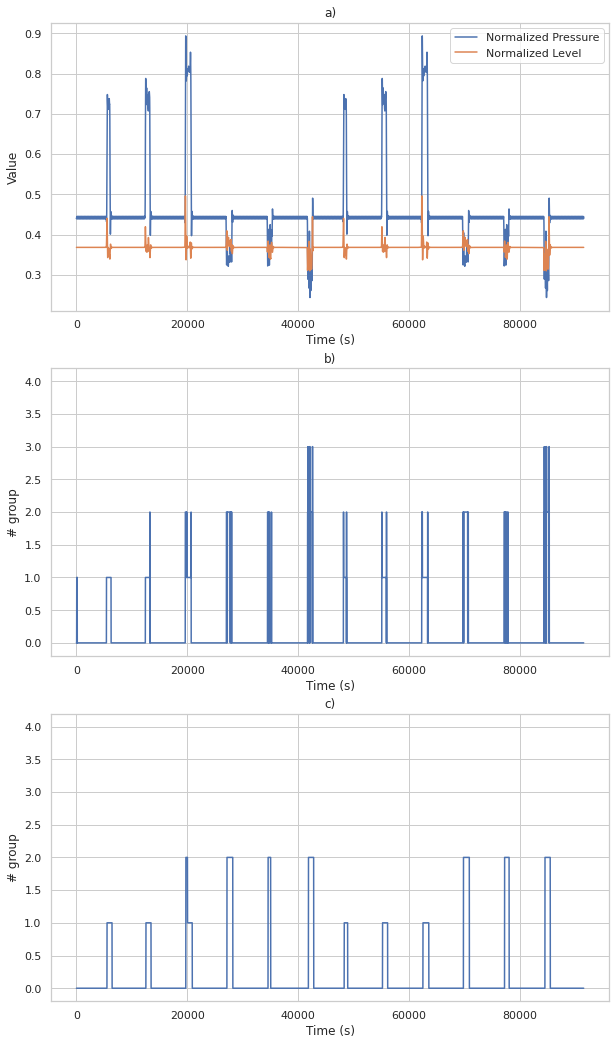

In [15]:

plt.figure(figsize=(10, 18))
plt.subplot(311)
plt.plot(data_f)
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.legend(["Normalized Pressure","Normalized Level"])
plt.title('a)')
plt.subplot(312)

plt.xlabel("Time (s)")
plt.ylabel("# group")
plt.plot(result_f)
plt.ylim(-0.2,4.2)
plt.title('b)')
plt.subplot(313)


plt.xlabel("Time (s)")
plt.ylabel("# group")
result_filter_time = filter_time(result_f, 180,  100)
plt.ylim(-0.2,4.2)
plt.title('c)')
plt.plot(result_filter_time)

In [16]:
target = np.concatenate((np.zeros(5419),np.ones(730),np.zeros(6184),np.ones(1046),np.zeros(6220),np.ones(1194),np.zeros(6206),2*np.ones(1200),np.zeros(6200),2*np.ones(1100),np.zeros(6100),2*np.ones(1100),np.zeros(5419),np.ones(730),np.zeros(6184),np.ones(1046),np.zeros(6220),np.ones(1194),np.zeros(6206),2*np.ones(1200),np.zeros(6200),2*np.ones(1100),np.zeros(6100),2*np.ones(1100),np.zeros(6185)),axis=0)

Performance results for fault scenario

In [17]:
from sklearn.metrics import classification_report
print(classification_report(target[3:],result_filter_time))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     78840
         1.0       0.85      0.76      0.80      5940
         2.0       0.89      0.74      0.81      6800

    accuracy                           0.95     91580
   macro avg       0.90      0.83      0.86     91580
weighted avg       0.95      0.95      0.95     91580



Performance results with data cluster assessment metrics

In [18]:
from sklearn import metrics
metrics.adjusted_rand_score(target[43003:],result_filter_time[43000:])

0.7932182876842485

In [19]:
metrics.homogeneity_score(target[43003:],result_filter_time[43000:])

0.6233911151755853

In [20]:
metrics.completeness_score(target[43003:],result_filter_time[43000:])

0.6959343335380183

In [21]:
metrics.v_measure_score(target[43003:],result_filter_time[43000:])

0.6576683269412471

# Second fault scenario

Load data set

In [22]:
data_fault_1 = pd.read_csv('f_07_12.csv')
constrained_vars = ["%0d" % v for v in [2,3]]
data_f = np.array(data_fault_1[constrained_vars])
df = pd.DataFrame(data_f, columns=['1','2'])

Pre-processing

In [23]:
import pandas as pd
from sklearn import preprocessing

x = data_f
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_f = x_scaled

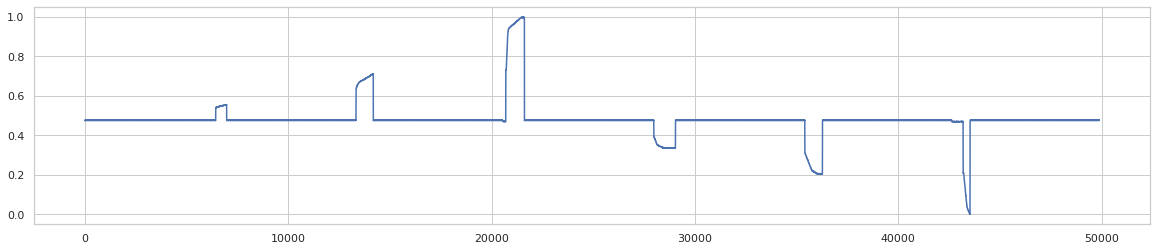

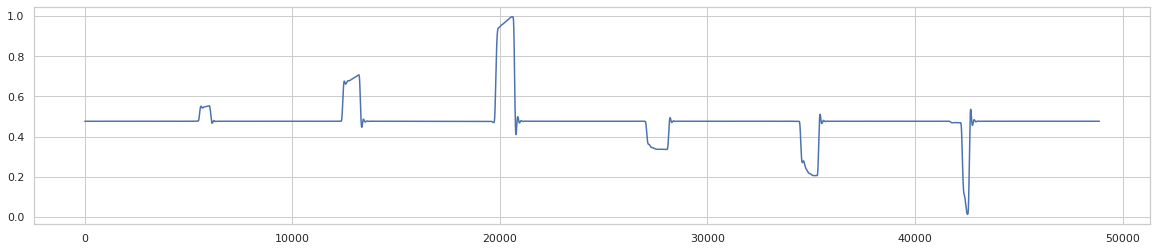

In [24]:
freq = 400
cutoff = 5

data = data_f[:,0]
plt.figure(figsize=(20,4)) 
plt.plot(data)
plt.show()
b, a = butter(5, (cutoff/freq), btype='low', analog=False)
data = lfilter(b, a, data)[1000:]
plt.figure(figsize=(20,4)) 
plt.plot(data)
plt.show()

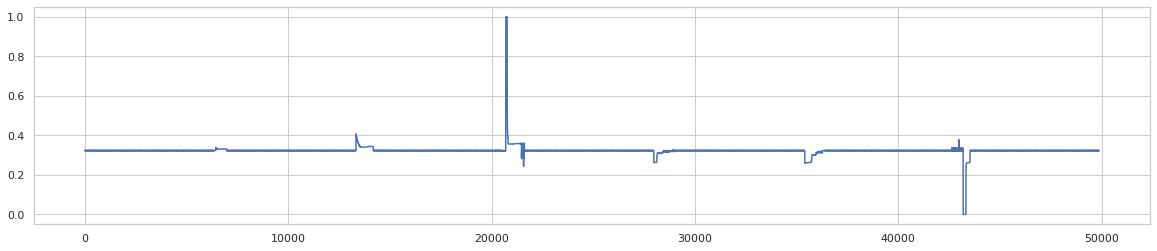

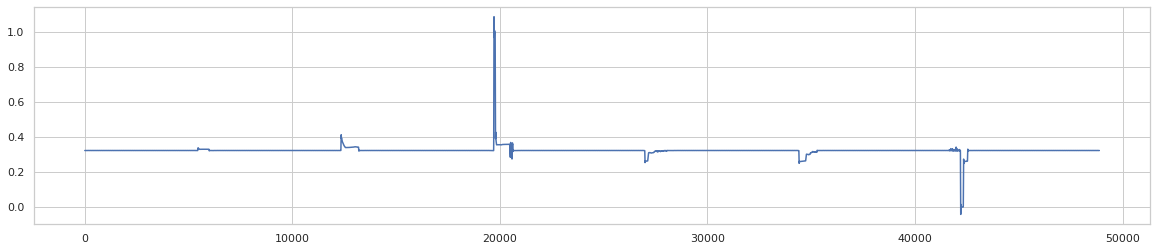

In [25]:
freq = 50
cutoff = 5

data_1 = data_f[:,1]
plt.figure(figsize=(20,4)) 
plt.plot(data_1)
plt.show()
b, a = butter(5, (cutoff/freq), btype='low', analog=False)
data_1 = lfilter(b, a, data_1)[1000:]
plt.figure(figsize=(20,4))
plt.plot(data_1)
plt.show()

In [26]:

result_window = pd.DataFrame(data)
result_window = result_window.rolling(window=4).mean()
data = result_window.values

result_window = pd.DataFrame(data_1)
result_window = result_window.rolling(window=1).mean()
data_1 = result_window.values

data = data[3:,0]
data_1 = data_1[3:,0]

data_f = np.array([data,data_1]).T
teste = AutoCloud(2.9)

In [27]:
for t in data_f:
    teste.run(np.array(t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


In [28]:
result_f = teste.classIndex

Result

Text(0.5, 1.0, 'c)')

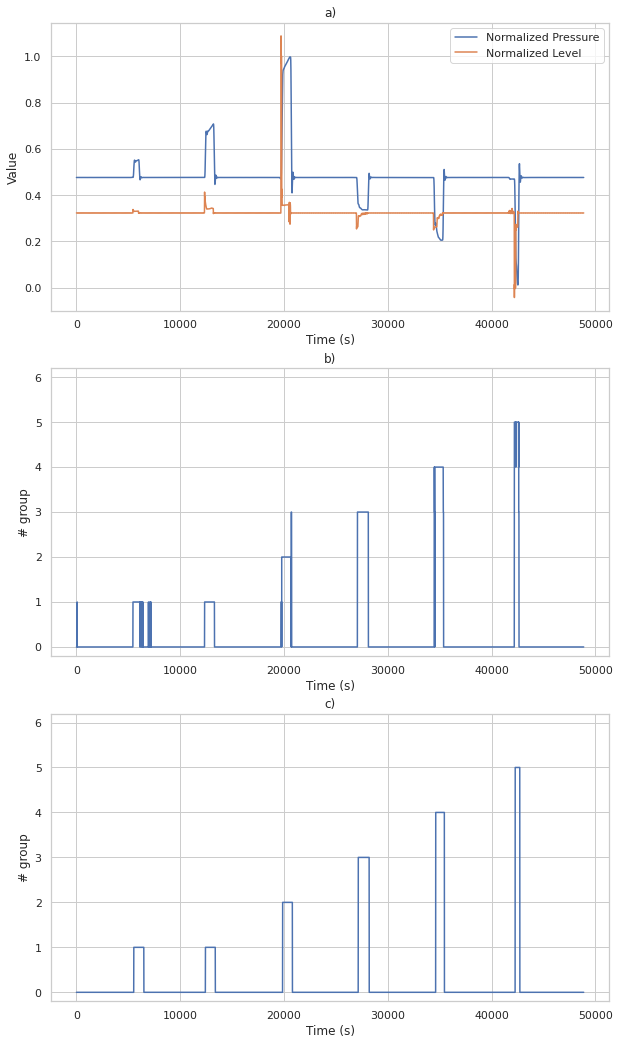

In [29]:
plt.figure(figsize=(10,18)) 
sns.set(style= 'whitegrid' )
plt.subplot(311)

plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.plot(data_f[:,0])
plt.plot(data_f[:,1])
plt.legend(["Normalized Pressure","Normalized Level"])
plt.title('a)')
plt.subplot(312)

plt.xlabel("Time (s)")
plt.ylabel("# group")

plt.plot(result_f)
plt.title('b)')
plt.ylim(-0.2,6.2)

#Filter time
plt.subplot(313)
plt.xlabel("Time (s)")
plt.ylabel("# group")

plt.ylim(-0.2,6.2)
result_filter_time = filter_time(result_f,80,80)
plt.plot(result_filter_time)
target = np.concatenate((np.zeros(5459),np.ones(740),np.zeros(6134),np.ones(1060),np.zeros(6306),2*np.ones(1094),np.zeros(6206),3*np.ones(1200),np.zeros(6200),4*np.ones(1000),np.zeros(6800),5*np.ones(500),np.zeros(6185)),axis=0)
plt.title('c)')



In [30]:
from sklearn.metrics import classification_report
print(classification_report(target[3:],result_f))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     43287
         1.0       0.88      0.94      0.91      1800
         2.0       1.00      0.84      0.91      1094
         3.0       0.91      0.88      0.89      1200
         4.0       0.98      0.84      0.90      1000
         5.0       0.99      0.81      0.89       500

    accuracy                           0.98     48881
   macro avg       0.96      0.88      0.92     48881
weighted avg       0.98      0.98      0.98     48881



In [31]:
from sklearn import metrics
metrics.adjusted_rand_score(target[3:],result_filter_time)

0.8672373162724819

In [32]:
metrics.homogeneity_score(target[3:],result_filter_time)

0.7555140182370147

In [33]:
metrics.completeness_score(target[3:],result_filter_time)

0.8037424826699407

In [34]:
metrics.v_measure_score(target[3:],result_filter_time)

0.7788823870306845

#Third fault scenario

In [35]:
data_fault_1 = pd.read_csv('f_3_6_9_12.csv')
constrained_vars = ["%0d" % v for v in [2,3]]
data_f = np.array(data_fault_1[constrained_vars])
df = pd.DataFrame(data_f, columns=['1','2'])

pre-prossing

In [36]:
import pandas as pd
from sklearn import preprocessing

x = data_f
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_f = x_scaled

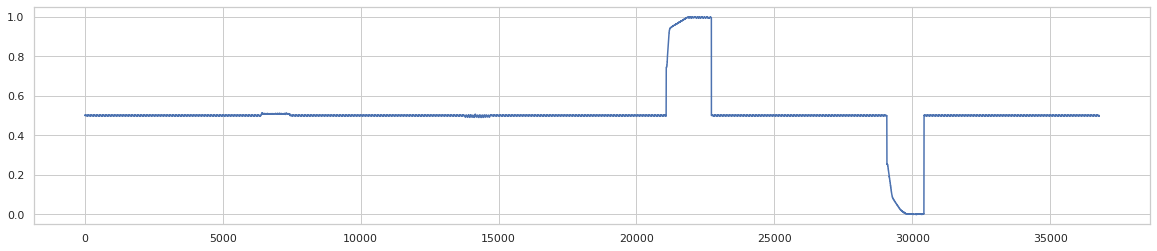

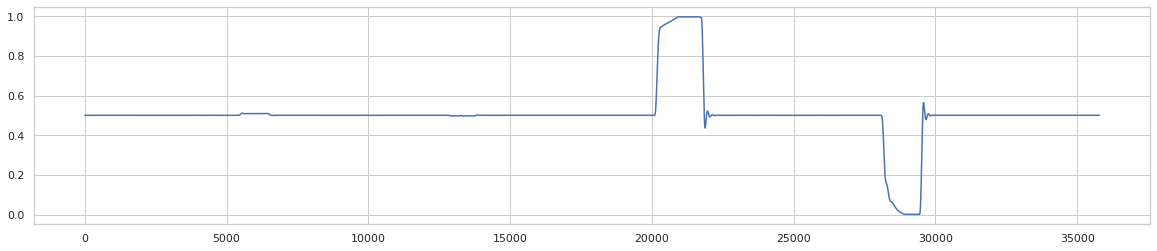

In [37]:
freq = 400
cutoff = 5

data = data_f[:,0]
plt.figure(figsize=(20,4)) 
plt.plot(data)
plt.show()
b, a = butter(5, (cutoff/freq), btype='low', analog=False)
data = lfilter(b, a, data)[1000:]
plt.figure(figsize=(20,4)) 
plt.plot(data)
plt.show()


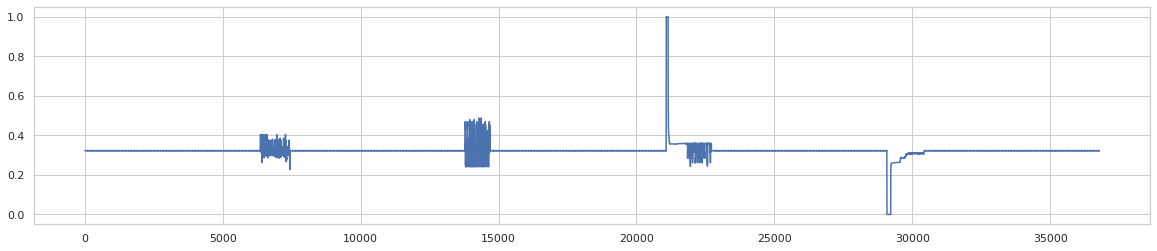

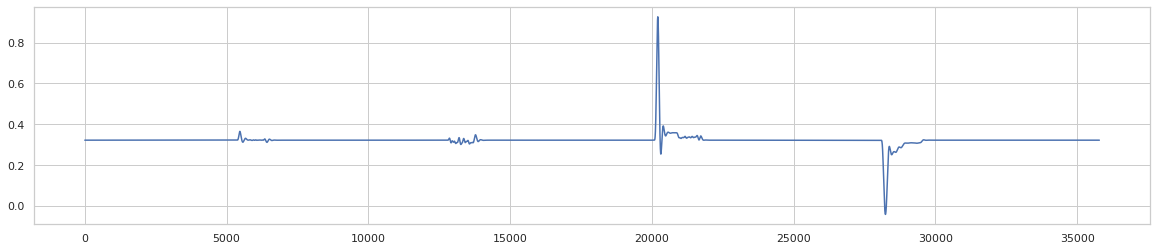

In [38]:
freq = 400
cutoff = 5

data_1 = data_f[:,1]
plt.figure(figsize=(20,4)) 
plt.plot(data_1)
plt.show()
b, a = butter(5, (cutoff/freq), btype='low', analog=False)
data_1 = lfilter(b, a, data_1)[1000:]
plt.figure(figsize=(20,4))
plt.plot(data_1)
plt.show()

In [39]:
result_window = pd.DataFrame(data)
result_window = result_window.rolling(window=1).mean()
data = result_window.values

result_window = pd.DataFrame(data_1)
result_window = result_window.rolling(window=3).mean()
data_1 = result_window.values

data = data[20:,0]
data_1 = data_1[20:,0]

data_f = np.array([data,data_1]).T
teste = AutoCloud(2.35)

In [40]:
for t in data_f:
    teste.run(np.array(t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


In [41]:
result_f = teste.classIndex
result_filter_time = filter_time(result_f,80,80)

Text(0.5, 1.0, 'c)')

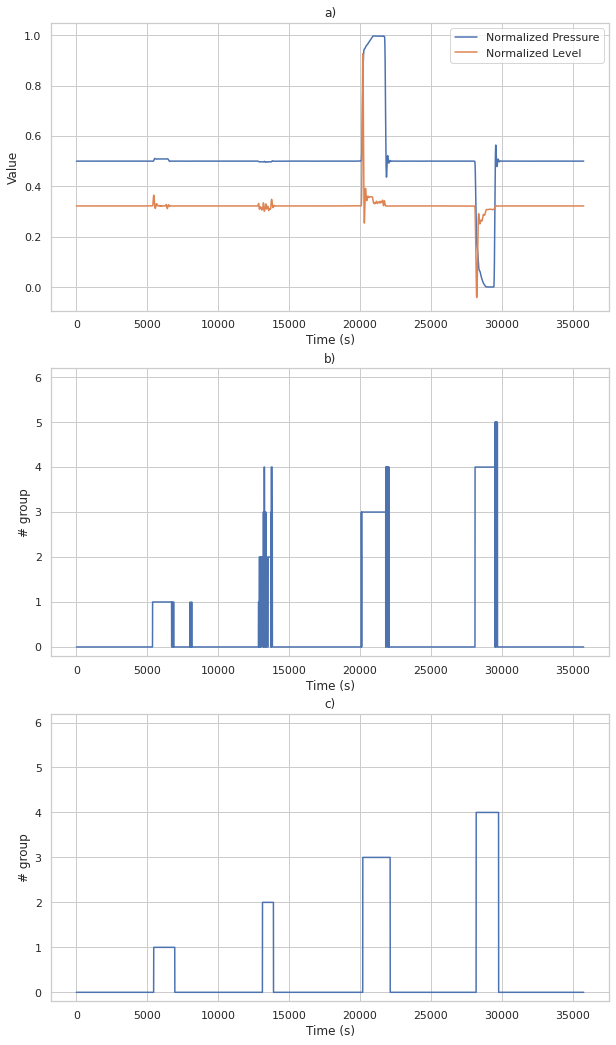

In [42]:
plt.figure(figsize=(10,18)) 
sns.set(style= 'whitegrid' )
plt.subplot(311)

plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.plot(data_f[:,0])
plt.plot(data_f[:,1])
plt.legend(["Normalized Pressure","Normalized Level"])
plt.title('a)')
plt.subplot(312)

plt.xlabel("Time (s)")
plt.ylabel("# group")
plt.plot(result_f)

plt.title('b)')
plt.ylim(-0.2,6.2)
#Filter time
plt.subplot(313)
plt.xlabel("Time (s)")
plt.ylabel("# group")

plt.ylim(-0.2,6.2)
plt.plot(result_filter_time)
plt.title('c)')


In [43]:
target = np.concatenate((np.zeros(5360),np.ones(1290),np.zeros(6135),2*np.ones(1100),np.zeros(6162),3*np.ones(2300),np.zeros(5707),4*np.ones(1600),np.zeros(6111)),axis=0)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(target,result_filter_time))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     29475
         1.0       0.81      0.94      0.87      1290
         2.0       1.00      0.70      0.82      1100
         3.0       1.00      0.84      0.91      2300
         4.0       0.93      0.92      0.93      1600

    accuracy                           0.96     35765
   macro avg       0.94      0.88      0.90     35765
weighted avg       0.97      0.96      0.96     35765



In [45]:
from sklearn import metrics
metrics.adjusted_rand_score(target,result_filter_time)

0.8531473755557616

In [46]:
metrics.homogeneity_score(target,result_filter_time)

0.7500535670503707

In [47]:
metrics.completeness_score(target,result_filter_time)

0.7986838385073256

In [48]:
metrics.v_measure_score(target,result_filter_time)

0.7736052088212894